In [10]:
from datetime import datetime as dt
import datetime
import pygmo as pg
import pykep as pk
import numpy as np
from scipy import array
import pandas as pd
import plotly.graph_objects as go

In [142]:
min_date = '2020-04-01'
max_date = '2021-01-01'

parsed_start_date = dt.strptime(min_date, '%Y-%m-%d').date()
parsed_end_date = dt.strptime(max_date, '%Y-%m-%d').date()

origin = 'earth'
destination = 'jupiter'


In [148]:
# Epoch range (x axis)
initial_epoch_date = datetime.date(2000, 1, 1)

start_epoch = float((parsed_start_date - initial_epoch_date).days)
end_epoch = float((parsed_end_date - initial_epoch_date).days)
start_epochs = np.arange(start_epoch, end_epoch, 1.0)

# Time of flight (y axis)
duration = np.arange(180.0, 470.0, 1.0)

# Origin
earth = pk.planet.jpl_lp(origin)
# Destination
mars = pk.planet.jpl_lp(destination)

In [144]:
data = list()
for start in start_epochs:
    row = list()
    for T in duration:
        r1,v1 = earth.eph(pk.epoch(start, 'mjd2000'))
        r2,v2 = mars.eph(pk.epoch(start+T, 'mjd2000'))
        l = pk.lambert_problem(r1, r2, T*60*60*24, pk.MU_SUN)
        DV1 = np.linalg.norm(np.array(v1) - np.array(l.get_v1()[0]))
        DV2 = np.linalg.norm(np.array(v2) - np.array(l.get_v2()[0]))
        DV1 = max([0, DV1 - start_epoch])
        DV = DV1 + DV2
        row.append(DV)
    data.append(row)

minrows = [min(l) for l in data]
i_idx = np.argmin(minrows)
j_idx = np.argmin(data[i_idx])

In [145]:
duration_pl, start_epochs_pl = np.meshgrid(duration, start_epochs)

date_series = pd.to_datetime([i[0] for i in start_epochs_pl],
    unit='d',
    origin=pd.Timestamp('2000-01-01')
    )

date_vals = [str(i)[:10] for i in date_series.values]

In [146]:
fig = go.Figure(data =
    go.Contour(
        z = np.array(data).T,
        x = date_vals, # horizontal axis
        y = duration_pl[0], # vertical axis
        colorscale = 'thermal',
        contours = dict(
            start = data[i_idx][j_idx],
            end = 7000,
            size = 100,
        ),
        xcalendar = 'julian',
        contours_coloring = 'lines',
        line_width  =1,
        colorbar = dict(
            title = 'Delta V (m/s)', # title here
            titleside = 'right',
            titlefont = dict(
                family = "Courier New, monospace",
                size = 18,
                color = "#7f7f7f"
                )
        ),
    ))

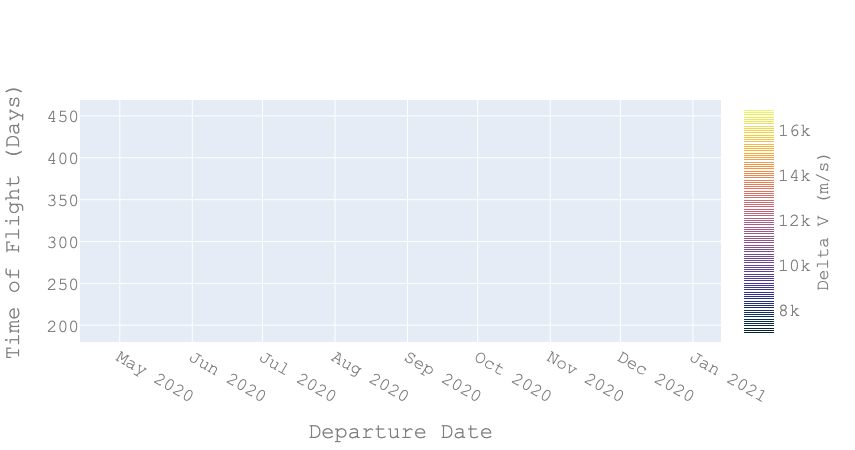

In [147]:
fig.update_layout(
    xaxis_title = "Departure Date",
    yaxis_title = "Time of Flight (Days)",
    font = dict(
        family = "Courier New, monospace",
        size = 18,
        color = "#7f7f7f"
    )
)

fig.show()